Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, RandomBrightness
import glob
import Augmentor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Melanoma_Detection/Train")
data_dir_test = pathlib.Path("Melanoma_Detection/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2, 
    subset='training',
    labels='inferred',  
    label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    labels='inferred',
    label_mode='categorical'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

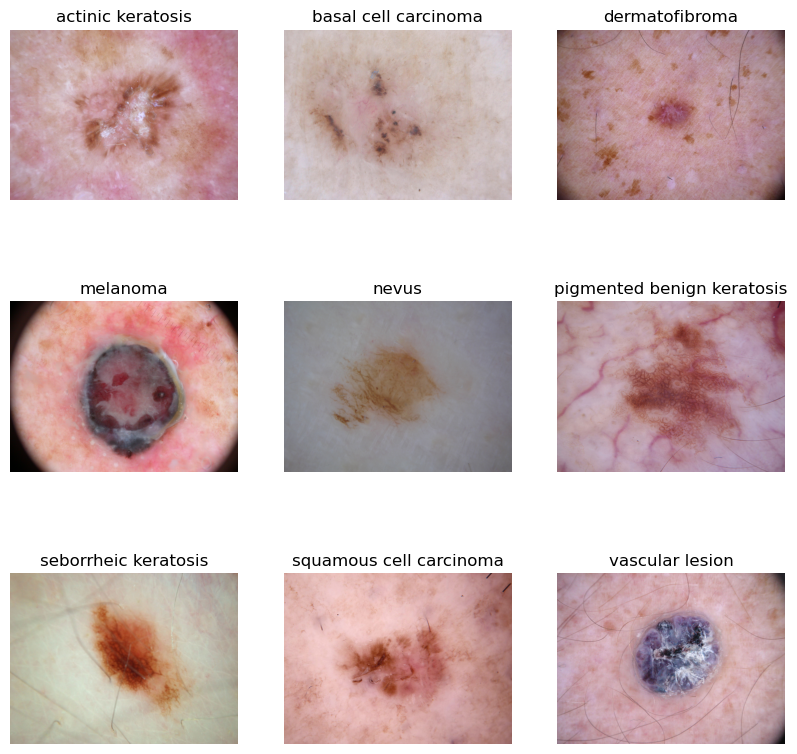

In [15]:

# Plot one instance for each class
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[random.randint(1, 50)]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
epochs = 50

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
### Your code goes here
model = Sequential([
    # Rescaling layer as the first layer
    Rescaling(scale=1.0/255, input_shape=(180, 180, 3)),
    
    # Add the rest of the model layers
    tf.keras.layers.Conv2D(16, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,294,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1867 - loss: 3.7150 - val_accuracy: 0.3691 - val_loss: 1.7648
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.3788 - loss: 1.6698 - val_accuracy: 0.4631 - val_loss: 1.5862
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.4795 - loss: 1.4783 - val_accuracy: 0.5369 - val_loss: 1.3777
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.5826 - loss: 1.2402 - val_accuracy: 0.5011 - val_loss: 1.5038
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.5821 - loss: 1.1925 - val_accuracy: 0.5638 - val_loss: 1.3688
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.6596 - loss: 0.9811 - val_accuracy: 0.5078 - val_loss: 1.5445
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.6909 - loss: 0.9323 - val_accuracy: 0.5459 - val_loss: 1.4110
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.7260 - loss: 0.8040 - val_accuracy: 0

### Visualizing training results

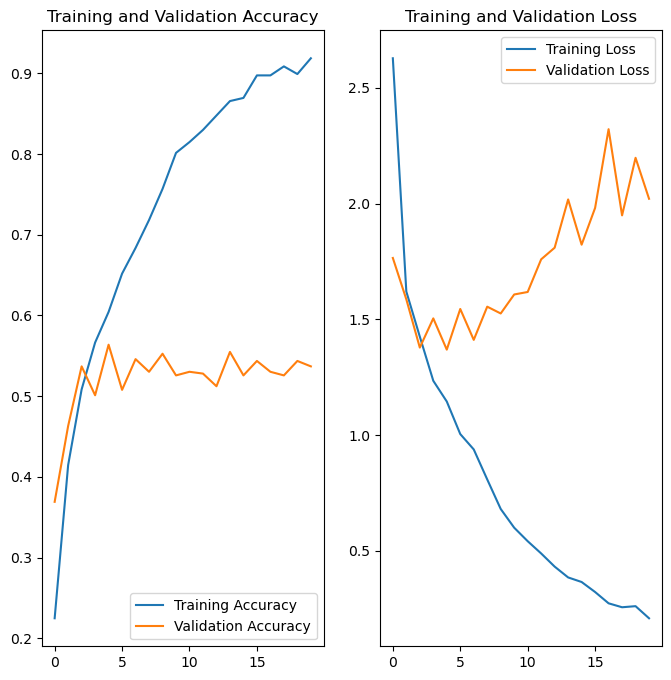

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings:
1. Model has High Training Accuracy but Low Validation Accuracy as training accuracy keeps increasing, but validation accuracy stagnates or decreases.
2. There is large gap between Training and Validation Loss as the training loss decreases steadily, but validation loss starts increasing.

 So, this model is overfitted with high training accuracy of 0.9205 and low validation accuracy of 0.5369.


In [44]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, RandomBrightness

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.7),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.9)
])

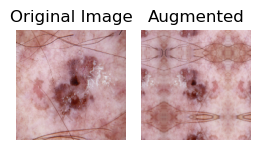

In [46]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image, _ in train_ds.take(1):
    plt.subplot(2, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.axis("off")
    #for i in range(1, 10):
    augmented_image = data_augmentation(image) 
    plt.subplot(2, 5, 2)
    plt.title("Augmented")
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.tight_layout()
    plt.show()

### Todo:
### Create the model, compile and train the model


In [58]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes her
model = Sequential([
    # Rescaling layer as the first layer
    Rescaling(scale=1.0/255, input_shape=(180, 180, 3)),
    # Add the rest of the model layers
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax')
])



### Compiling the model

In [60]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [65]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - accuracy: 0.1584 - loss: 5.6605 - val_accuracy: 0.1499 - val_loss: 2.1370
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.1861 - loss: 2.0993 - val_accuracy: 0.2349 - val_loss: 2.1200
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.2555 - loss: 2.0224 - val_accuracy: 0.2998 - val_loss: 1.9838
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.2845 - loss: 1.9024 - val_accuracy: 0.3960 - val_loss: 1.6968
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.3127 - loss: 1.8835 - val_accuracy: 0.4004 - val_loss: 1.7830
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.4269 - loss: 1.6666 - val_accuracy: 0.5078 - val_loss: 1.6995
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.4195 - loss: 1.6369 - val_accuracy: 0.4922 - val_loss: 1.6296
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.4759 - loss: 1.5216 - val_accu

### Visualizing the results

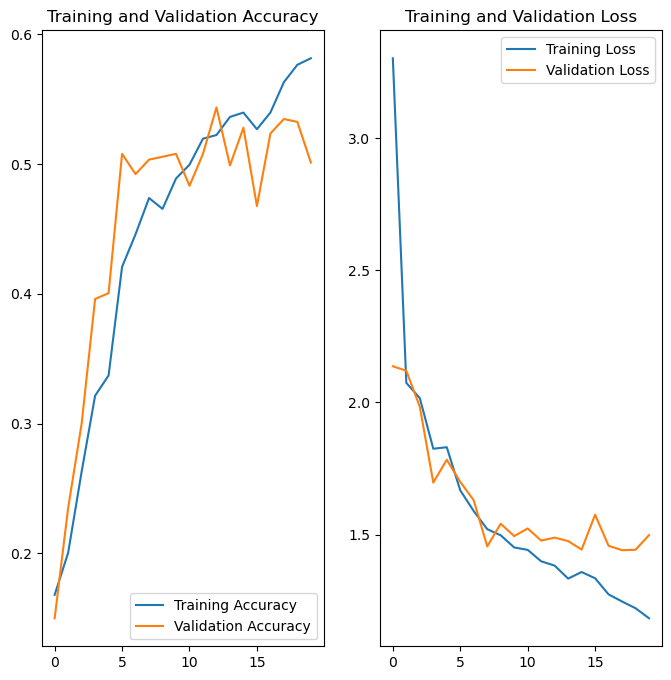

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings:
The model is now underfitted as the metric values are low. It has not learnt the patterns well.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [69]:

path_list = [x for x in glob.glob(os.path.join(data_dir_train,'*', '*.jpg'))]
path_list

['Melanoma_Detection/Train/melanoma/ISIC_0010550.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0011128.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010587.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010034.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000555.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010746.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0001105.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010791.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010785.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010140.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000390.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000151.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000145.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010394.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0010380.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000144.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000150.jpg',
 'Melanoma_Detection/Train/melanoma/ISIC_0000420.jpg',
 'Melanoma

In [71]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [73]:
dataframe_dict= dict(zip(path_list, lesion_list))

In [75]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [77]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
- seborrheic keratosis' has least number of samples which is 77.
#### - Which classes dominate the data in terms proportionate number of samples? 
- Dominant Classes:  'pigmented benign keratosis': 462, 'melanoma': 438, 'basal cell carcinoma': 376, 'nevus': 357

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [80]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [83]:
path_to_training_dataset=data_dir_train
for i in class_names:
    p = Augmentor.Pipeline(f'{path_to_training_dataset}/{i}')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Melanoma_Detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15D3E5690>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Melanoma_Detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15D35CF10>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to Melanoma_Detection/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 438 image(s) found.
Output directory set to Melanoma_Detection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x15D360F90>: 100%|█


Initialised with 357 image(s) found.
Output directory set to Melanoma_Detection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x15D2430D0>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to Melanoma_Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15D301850>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Melanoma_Detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16E495390>: 100%|█


Initialised with 181 image(s) found.
Output directory set to Melanoma_Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15C6D0BD0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Melanoma_Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15C6ED9D0>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [85]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [87]:

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0000173.jpg_14a6b199-e7a8-44dc-9d29-22fc677ec80d.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0010407.jpg_20cf5291-12f3-4296-bbc1-8782c1cd6ab5.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0009918.jpg_fb59f6ae-e790-4c47-9983-20a58c87bdd6.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0010772.jpg_fc46cd0f-d55b-4a13-9904-9fbe345d9ce0.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_f585f978-22a7-47a6-a2f8-dd1d12eeae65.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0000308.jpg_cff3848b-18e5-471a-8e65-883a56b3eb37.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_4cac62fb-b102-4737-972e-f3111975871d.jpg',
 'Melanoma_Detection/Train/melanoma/output/melanoma_original_ISIC_0001143.jpg_be0793d9-af8a-4124-8456-fc881c9a0097.jpg',
 'Melanoma_Detection/Train/melan

In [89]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [91]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [93]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [95]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [97]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [110]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    seed=123,           
    validation_split=0.2,
    subset='training',  
    label_mode='categorical'
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [114]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    seed=123,            
    validation_split=0.2,
    subset='validation',
    label_mode='categorical'
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [134]:
## your code goes here
model = Sequential([
    Rescaling(scale=1.0/255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [137]:
## your code goes here
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [139]:
# View the summary of all layers
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,042,633 (15.42 MB)

 Trainable params: 4,042,249 (15.42 MB)

 Non-trainable params: 384 (1.50 KB)

#### **Todo:**  Train your model

In [142]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 141s 831ms/step - accuracy: 0.2779 - loss: 2.5296 - val_accuracy: 0.1158 - val_loss: 5.2253
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 144s 853ms/step - accuracy: 0.4078 - loss: 1.5587 - val_accuracy: 0.2576 - val_loss: 2.9497
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 163s 966ms/step - accuracy: 0.4757 - loss: 1.4066 - val_accuracy: 0.4484 - val_loss: 1.6542
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 169s 999ms/step - accuracy: 0.5410 - loss: 1.2165 - val_accuracy: 0.5976 - val_loss: 1.0675
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5917 - loss: 1.0690 - val_accuracy: 0.5442 - val_loss: 1.2847
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.6394 - loss: 0.9698 - val_accuracy: 0.4870 - val_loss: 1.4289
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6745 - loss: 0.8570 - val_accuracy: 0.5961 - val_loss: 1.1235
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7142 - loss: 0.750

#### **Todo:**  Visualize the model results

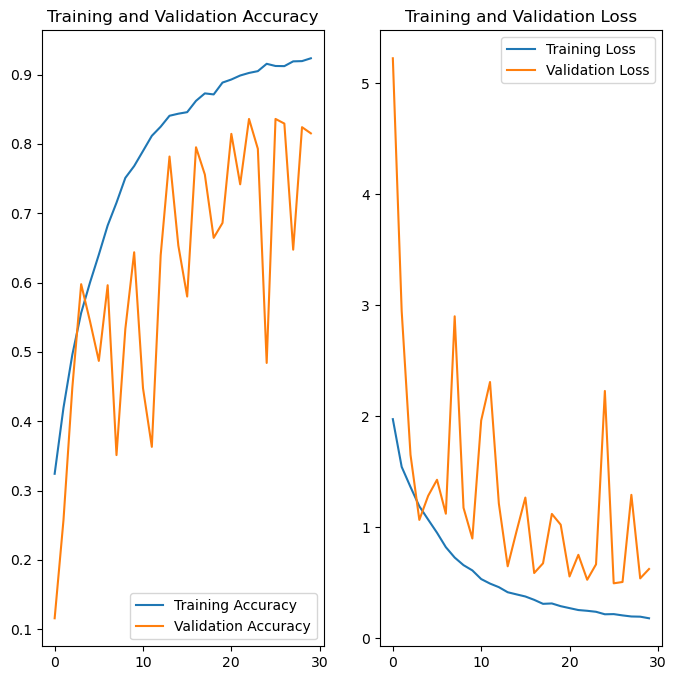

In [145]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

